In [4]:
import pandas as pd

# =========================
# 1. Load datasets
# =========================

# Load NEFSC observations with CHL/carbon (MOANA data)
moana_df = pd.read_csv('/home/jovyan/2026_proj_megafauna/data/NEFSC_Offshore_Carbon_Chl_MOANA_Depth.csv')

# Load SST observations
sst_df = pd.read_csv('/home/jovyan/2026_proj_megafauna/data/NEFSC_Offshore_Obs_With_SST.csv')

# Load SSH anomaly data
ssha_df = pd.read_csv('/home/jovyan/2026_proj_megafauna/data/NEFSC_offshore_obs_with_SSHA.csv')

# =========================
# 2. Merge datasets
# =========================

# Merge MOANA data with SST by matching latitude, longitude, date, and species
combined_df = moana_df.merge(
    sst_df[['latitude', 'longitude', 'date_time', 'common_name', 'sst_median', 'sst_std']],
    on=['latitude', 'longitude', 'date_time', 'common_name'],
    how='left'
)

# Merge with SSHA using 'Original_Index' from SSHA file
# First ensure indices match by adding Original_Index if missing
if 'Original_Index' not in combined_df.columns and 'Original_Index' in ssha_df.columns:
    combined_df['Original_Index'] = combined_df.index

combined_df = combined_df.merge(
    ssha_df[['Original_Index', 'ssha']],
    on='Original_Index',
    how='left'
)

# =========================
# 3. Save combined CSV
# =========================

output_file = '/home/jovyan/2026_proj_megafauna/data/NEFSC_Offshore_Obs_With_SST_SSHA_CHL.csv'
combined_df.to_csv(output_file, index=False)

print(f"✅ Combined dataset saved: {output_file}")
print(f"Columns included: {list(combined_df.columns)}")
print(f"Total rows: {len(combined_df)}")


✅ Combined dataset saved: /home/jovyan/2026_proj_megafauna/data/NEFSC_Offshore_Obs_With_SST_SSHA_CHL.csv
Columns included: ['latitude', 'longitude', 'date_time', 'date', 'common_name', 'scientific_name', 'group_size', 'carbon_phyto_mean', 'carbon_phyto_median', 'carbon_phyto_std', 'carbon_phyto_min', 'carbon_phyto_max', 'carbon_phyto_q25', 'carbon_phyto_q75', 'chlor_a_mean', 'chlor_a_median', 'chlor_a_std', 'chlor_a_min', 'chlor_a_max', 'chlor_a_q25', 'chlor_a_q75', 'synechococcus_mean', 'synechococcus_median', 'synechococcus_std', 'synechococcus_min', 'synechococcus_max', 'synechococcus_q25', 'synechococcus_q75', 'prochlorococcus_mean', 'prochlorococcus_median', 'prochlorococcus_std', 'prochlorococcus_min', 'prochlorococcus_max', 'prochlorococcus_q25', 'prochlorococcus_q75', 'picoeukaryotes_mean', 'picoeukaryotes_median', 'picoeukaryotes_std', 'picoeukaryotes_min', 'picoeukaryotes_max', 'picoeukaryotes_q25', 'picoeukaryotes_q75', 'depth_m', 'sst_median', 'sst_std', 'Original_Index', '

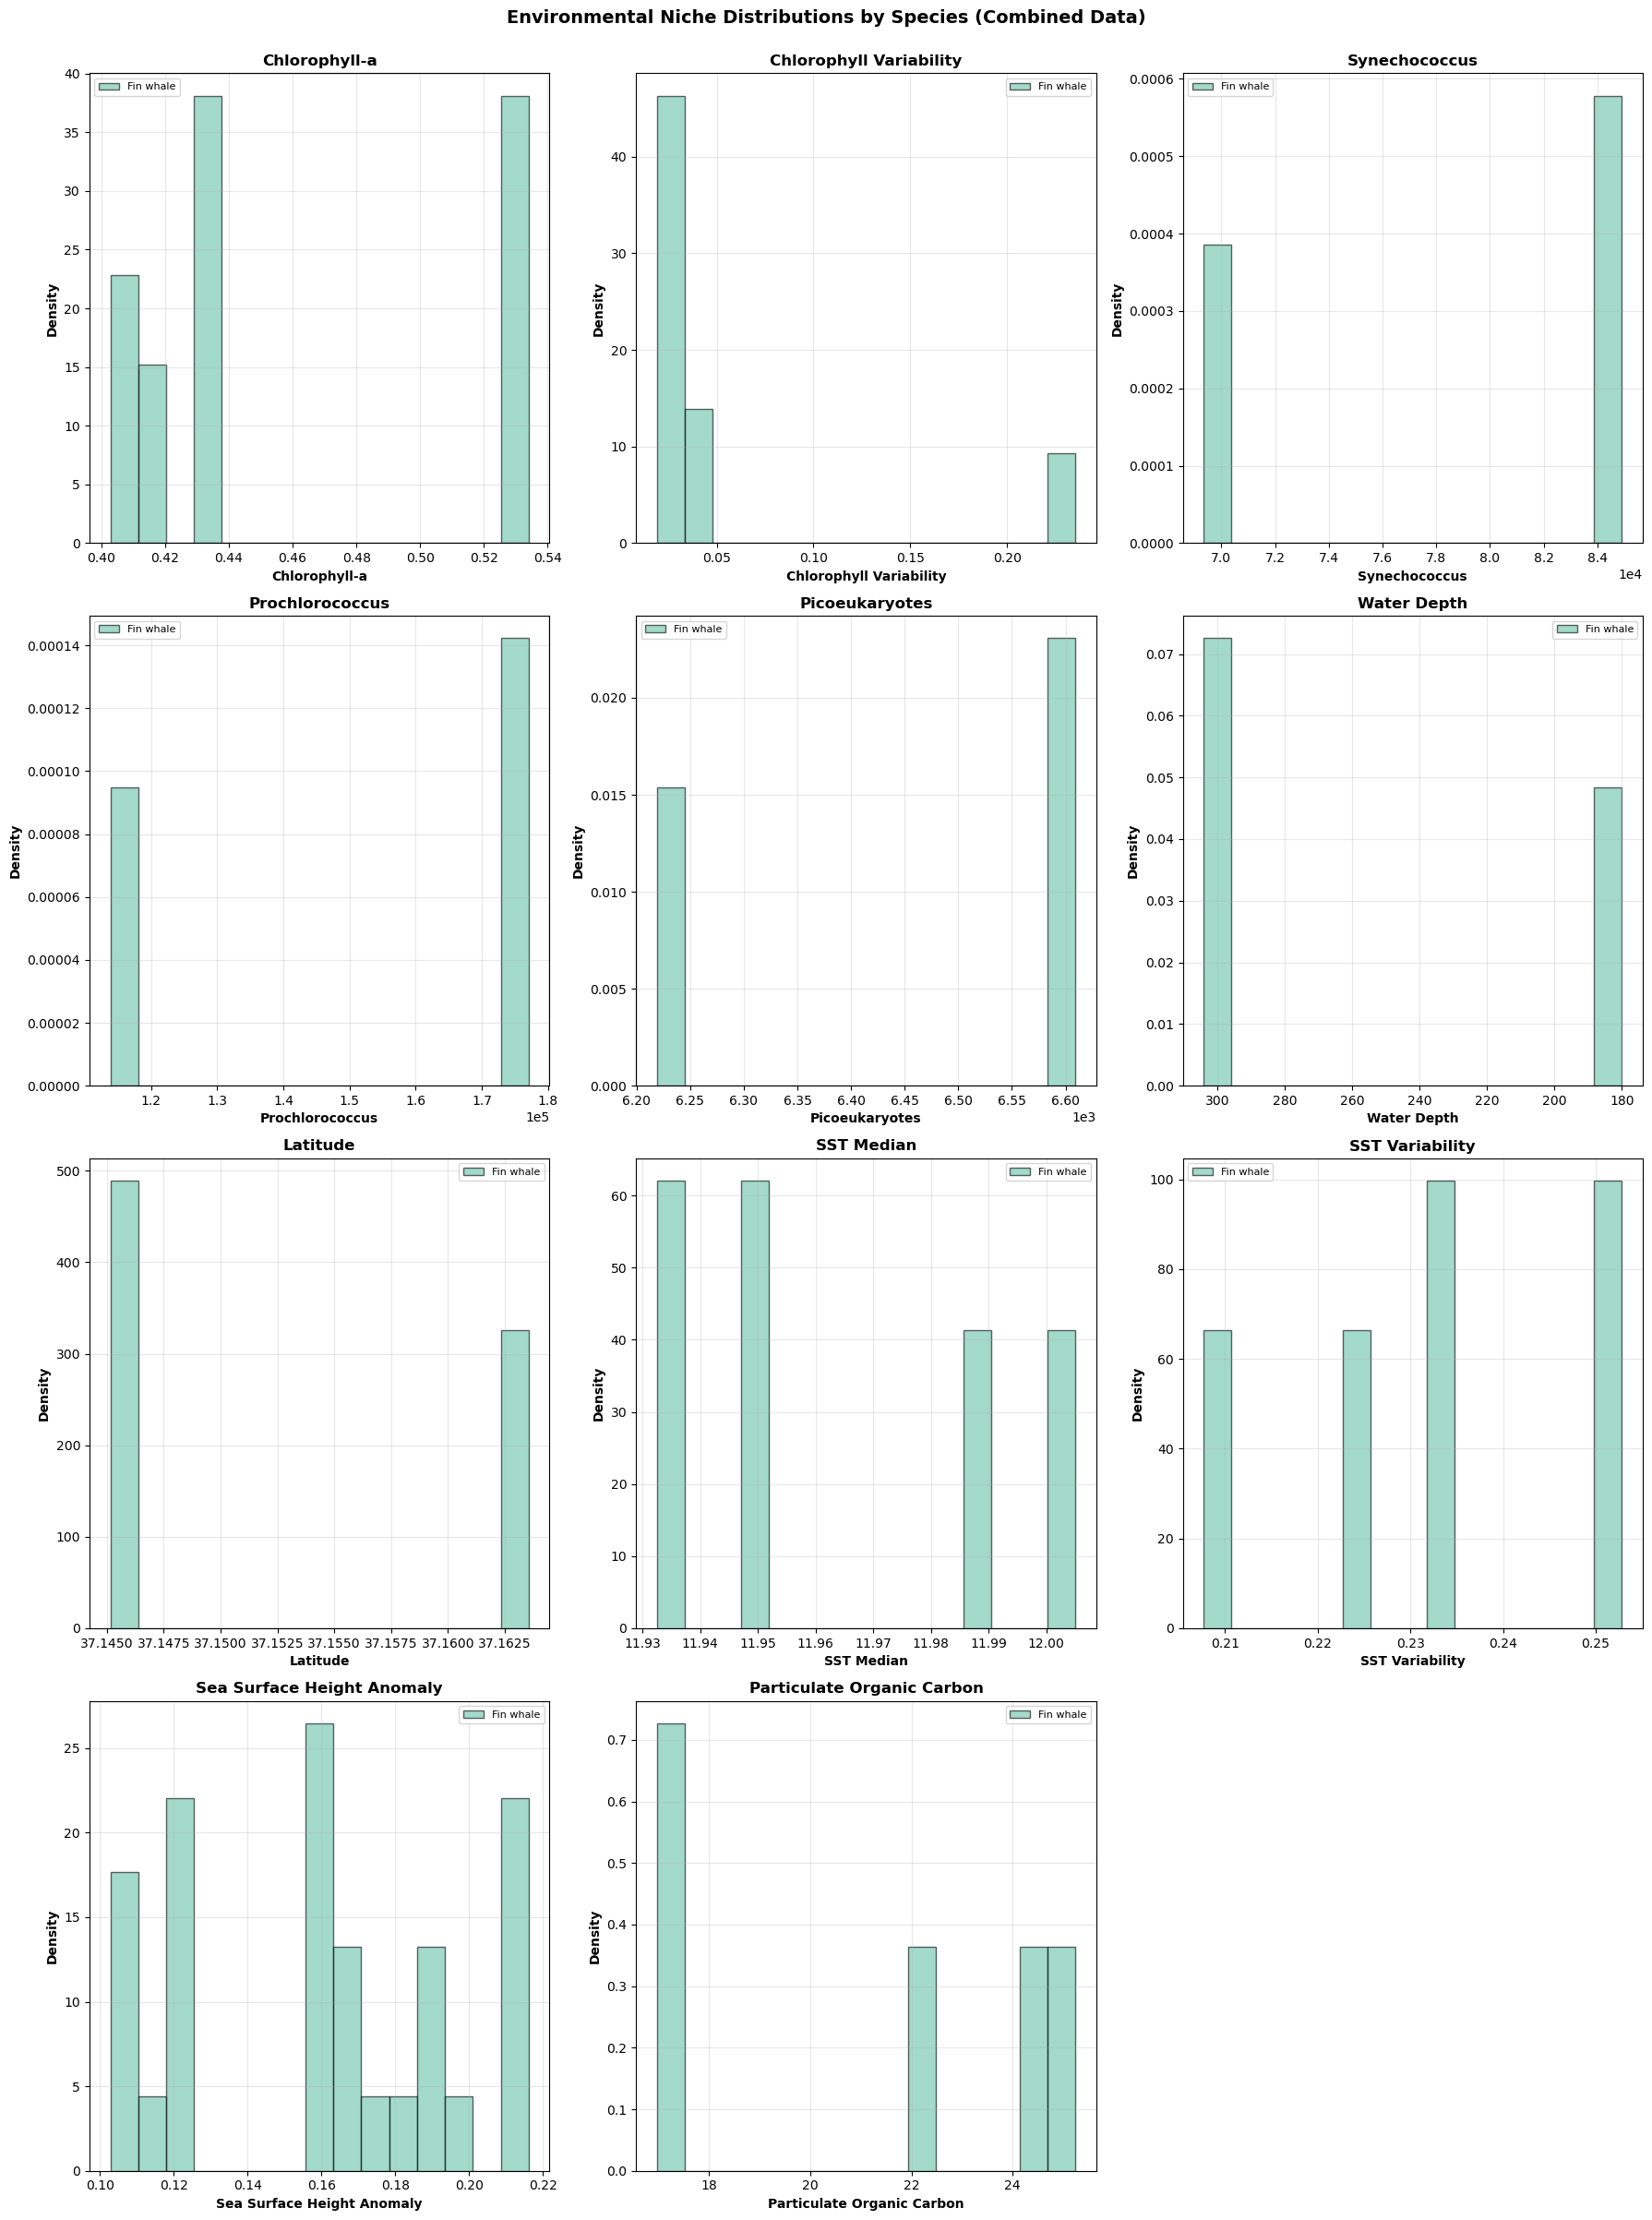

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import kruskal
from tqdm import tqdm

# -----------------------------
# LOAD COMBINED DATA
# -----------------------------
combined_file = '/home/jovyan/2026_proj_megafauna/data/NEFSC_Offshore_Obs_With_SST_SSHA_CHL.csv'
df = pd.read_csv(combined_file)

# -----------------------------
# DEFINE ENVIRONMENTAL VARIABLES
# -----------------------------
environmental_vars = {
    'chlor_a_median': 'Chlorophyll-a',
    'chlor_a_std': 'Chlorophyll Variability',
    'synechococcus_median': 'Synechococcus',
    'prochlorococcus_median': 'Prochlorococcus',
    'picoeukaryotes_median': 'Picoeukaryotes',
    'depth_m': 'Water Depth',
    'latitude': 'Latitude',
    'sst_median': 'SST Median',
    'sst_std': 'SST Variability',
    'ssha': 'Sea Surface Height Anomaly',
    'carbon_phyto_median': 'Particulate Organic Carbon'
}

# Keep only variables present in the dataset
existing_vars = {k:v for k,v in environmental_vars.items() if k in df.columns}

# -----------------------------
# CLEAN DATA
# -----------------------------
df_clean = df[list(existing_vars.keys()) + ['common_name']].dropna()
species_list = df_clean['common_name'].unique()

# -----------------------------
# SUMMARY STATISTICS
# -----------------------------
summary_stats = []
for species in species_list:
    species_data = df_clean[df_clean['common_name'] == species]
    stats_row = {'Species': species, 'N': len(species_data)}
    for var, label in existing_vars.items():
        stats_row[f'{label}_mean'] = species_data[var].mean()
        stats_row[f'{label}_std'] = species_data[var].std()
    summary_stats.append(stats_row)

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('/home/jovyan/2026_proj_megafauna/contributor_folders/AnaVaz/MultiVar_Species_Summary_Combined.csv', index=False)

# -----------------------------
# KRUSKAL-WALLIS TESTS
# -----------------------------
test_results = []
for var, label in existing_vars.items():
    groups = [df_clean[df_clean['common_name'] == sp][var].values for sp in species_list]
    groups = [g for g in groups if len(g) >= 3]
    if len(groups) >= 2:
        h_stat, p_val = kruskal(*groups)
        test_results.append({
            'Variable': label,
            'H_statistic': h_stat,
            'p_value': p_val,
            'Significant': 'Yes' if p_val < 0.05 else 'No'
        })

test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv('/home/jovyan/2026_proj_megafauna/contributor_folders/AnaVaz/Statistical_Tests_Combined.csv', index=False)

# -----------------------------
# MULTI-PANEL ENVIRONMENTAL DISTRIBUTIONS
# -----------------------------
n_vars = len(existing_vars)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
axes = axes.flatten()
colors = sns.color_palette("Set2", len(species_list))

for idx, (var, label) in enumerate(existing_vars.items()):
    ax = axes[idx]
    for species, color in zip(species_list, colors):
        data = df_clean[df_clean['common_name'] == species][var]
        if len(data) > 0:
            ax.hist(data, alpha=0.6, bins=15, density=True, color=color, edgecolor='black', label=species)
    ax.set_xlabel(label, fontweight='bold')
    ax.set_ylabel('Density', fontweight='bold')
    ax.set_title(label, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    if 'coccus' in var or 'euk' in var:
        ax.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))
    if var == 'depth_m':
        ax.invert_xaxis()

for idx in range(len(existing_vars), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Environmental Niche Distributions by Species (Combined Data)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('/home/jovyan/2026_proj_megafauna/contributor_folders/AnaVaz/MultiVar_Environmental_Distributions_Combined.png', dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# SPECIFIC VARIABLE PLOTS (Carbon, SST, SSHA)
# -----------------------------
for var_key in ['carbon_phyto_median','sst_median','ssha']:
    if var_key in df_clean.columns:
        var_label = existing_vars[var_key]

